In [1]:
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn import svm

from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold, cross_val_score,cross_validate

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, auc, RocCurveDisplay

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import fetch_openml

import seaborn as sns

import pandas as pd

In [2]:
## Load MNIST data
digits = load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
digit_label = digits.target


digit label: 0


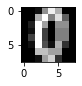

In [3]:
## Show one sample
sample_ind = 10
print("digit label:",digit_label[sample_ind] )
plt.figure(figsize = (1,1))
plt.imshow(data[sample_ind].reshape(8,8), cmap = "gray")

In [4]:
## Train test split

X_train, X_test, y_train, y_test = train_test_split(data, digit_label,
                                                    test_size=0.2, ## use 20% data for test
                                                    random_state=42, ## set random state for replication of experiment
                                                    stratify=digit_label ## stratify data instances based on their labels
                                                    )   
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (1437, 64)
Test data shape: (360, 64)


# Set up pipeline and gridsearch

In [5]:
## Initialize classifiers

clf1 = DecisionTreeClassifier(random_state=1)

clf2 = MLPClassifier(random_state=1)


## Initialize pipeline for Decision Tree and MLP repectively
pipe1 = Pipeline([('scaler', StandardScaler()),
                  ('clf1', clf1)])

pipe2 = Pipeline([('scaler', StandardScaler()),
                  ('clf2', clf2)])


## Setting up parameter grid

# Define the range of hyperparameter to search from
# The part can be change if you want to search other combinations of hyperparameters
param_grid_decisiontree = [{'clf1__max_depth': list(range(1, 10)) + [None]}]

param_grid_mlp = [{'clf2__hidden_layer_sizes': [(40,), (40,40)]}]



In [6]:
# Setting up multiple GridSearchCV objects

gridcvs = {} 
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1) # inner loop cross-validation with 4 folds

for pgrid, est, name in zip((param_grid_decisiontree, param_grid_mlp),
                            (pipe1, pipe2),
                            ('Decision Tree', 'MLP')):
    gcv = GridSearchCV(estimator=est,
                       param_grid=pgrid,
                       scoring = ['accuracy'], ## scoring metric can be also changed
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit="accuracy")
    gridcvs[name] = gcv
    
print(gridcvs)

{'Decision Tree': GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf1',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'clf1__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                              None]}],
             refit='accuracy', scoring=['accuracy']), 'MLP': GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf2',
                                        MLPClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'clf2__hidden_layer_sizes': [(40,), (40, 40)]}],
             refit='accuracy', scoring=['accuracy'])}


In [7]:
## Define outer loop
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)


def nested_cross_val(features, labels, gridcvs):
    """ nested cross validation to compare across ML methods.
        features: the training dataset,
        labels: the corresponding labels for the training data """
    for method, gridsearch in sorted(gridcvs.items()):
        print("Current method:",method)

        scores = cross_validate(gridsearch, 
                                       X=features, 
                                       y=labels, 
                                       cv=outer_cv,
                                       n_jobs=-1,
                                       return_estimator = True,
                                       scoring = ['accuracy', 'roc_auc_ovr'], ## roc_auc, f1 only works for binary class
                                       error_score="raise")

        auc = scores['test_roc_auc_ovr']
        accuracy = scores['test_accuracy']
        estimators = scores['estimator']
        
        for i in estimators:
            print(i.best_params_) # show the best parameter with highest prediction accuracy
            print('\n')
        print('outer loop accuracy %.2f%% +/- %.2f' % 
              (accuracy.mean() * 100, accuracy.std() * 100))
        print('outer loop AUC %.2f%% +/- %.2f' % 
              (auc.mean() * 100, auc.std() * 100))
        ## Similarlly, you can also print out other scoring metrics
        print('\n')
            

nested_cross_val(X_train, y_train, gridcvs)

Current method: Decision Tree
{'clf1__max_depth': None}


{'clf1__max_depth': 9}


{'clf1__max_depth': 8}


outer loop accuracy 83.16% +/- 1.66
outer loop AUC 91.07% +/- 0.98


Current method: MLP
{'clf2__hidden_layer_sizes': (40,)}


{'clf2__hidden_layer_sizes': (40, 40)}


{'clf2__hidden_layer_sizes': (40,)}


outer loop accuracy 96.17% +/- 0.77
outer loop AUC 99.85% +/- 0.09




In [8]:
## Fit the best model on the training set, and predict on the test set

def run_test(train_features, train_labels, 
             test_features, test_labels, 
             model_name, paramters, folds):
    """Fit the model on the entire training set, and
    test on the test set."""
    model_select = GridSearchCV(estimator=model_name,
                                param_grid=paramters,
                                scoring='accuracy',
                                n_jobs=-1,
                                cv=folds,
                                verbose=3, # display folds in computation steps
                                refit=True # need to be True in order to return best_estimator_ 
                               )

    ## Fit the model on the entire training dataset
    model_select.fit(train_features, train_labels)
    
    ## grad the model with the set of hyperparameters that gives the best mean prediction accuracy across cross-validation 
    best_model = model_select.best_estimator_
    
        
    train_acc = accuracy_score(y_true=train_labels, y_pred=best_model.predict(train_features))
    test_acc = accuracy_score(y_true=test_labels, y_pred=best_model.predict(test_features))

    print('Accuracy %.2f%% (average over k-fold CV test folds)' %
          (100 * model_select.best_score_))
    print('Best Parameters: %s' % model_select.best_params_)

    print('Best Training Accuracy: %.2f%%' % (100 * train_acc))
    print('Test Accuracy: %.2f%%' % (100 * test_acc))
    



In [9]:
## Standardize the test set
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=1) 


## Set up range of hyperparameters to search on MLP
param_grid_mlp =  [{'alpha': [0.1, 0.01, 0.01, 0.001, 0.0001],
                    'hidden_layer_sizes': [(40,), (100,)]}]
run_test(X_train, y_train, X_test, y_test, clf2, param_grid_mlp, folds)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Accuracy 97.36% (average over k-fold CV test folds)
Best Parameters: {'alpha': 0.1, 'hidden_layer_sizes': (100,)}
Best Training Accuracy: 100.00%
Test Accuracy: 83.89%


# K-fold with GridSearch
Example from sklearn: https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#sphx-glr-auto-examples-exercises-plot-cv-diabetes-py

In [10]:
# Example from sklearn: https://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#sphx-glr-auto-examples-exercises-plot-cv-diabetes-py
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold, cross_val_score,cross_validate

X, y = datasets.load_diabetes(return_X_y=True)
print(y.shape)
X = X[:150] # keep first 150 rows
y = y[:150] # keep first 150 rows

lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

print(alphas)

num_of_model = alphas.shape[0]

print("Show the total number of model being searched:",num_of_model)

tuned_parameters = [{"alpha": alphas}]
n_folds = KFold(n_splits=6, shuffle=True, random_state=1)

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X, y)

## Compute mean test score of each model across k-folds
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]


## Manually compute the mean test score across k-folds
mean_test_scores = []
for model_num in range(num_of_model):
    #print("current model:", model_num)
    all_score = []
    for fold in range(n_folds.n_splits):
        name = "split"+str(fold)+"_test_score"
        test_score_fold = clf.cv_results_[name][model_num] # get the test score of the 
        all_score.append(test_score_fold)
        #print("Scores of the model fit in k-fold: ",all_score)
    mean_score = sum(all_score)/len(all_score) # compute the average score across k-fold for each searched model
    mean_test_scores.append(mean_score)
    
mean_test_scores = np.array(mean_test_scores)
print("mean_test_score for each searched model:\n",mean_test_scores)

## check that this is equivalent to returned values from clf.cv_results_["mean_test_score"]
print("check whether this confirms the sklearn returned results:\n",np.array_equal(mean_test_scores, scores))


## Instead of using GridSearchCV, we can manually check the performance of each searched model in the test folds.
models_test_mean_cv = []
for alpha in alphas:
    # We manually loop through each possible "alpha" 
    current_model = Lasso(random_state=0, max_iter=10000, alpha = alpha) # define the current model's hyperparameters
    test_score = cross_validate(current_model, X, y, cv=n_folds)['test_score'] # cross validate across k held-out folds
    print(test_score)
    models_test_mean_cv.append(test_score.mean()) # for each model, compute the mean test_score across k held-out folds
models_test_mean_cv = np.array(models_test_mean_cv) 

print("check whether this confirms the GridSearchCV:\n",np.array_equal(models_test_mean_cv, scores))

(442,)
[1.00000000e-04 1.32035178e-04 1.74332882e-04 2.30180731e-04
 3.03919538e-04 4.01280703e-04 5.29831691e-04 6.99564216e-04
 9.23670857e-04 1.21957046e-03 1.61026203e-03 2.12611233e-03
 2.80721620e-03 3.70651291e-03 4.89390092e-03 6.46167079e-03
 8.53167852e-03 1.12648169e-02 1.48735211e-02 1.96382800e-02
 2.59294380e-02 3.42359796e-02 4.52035366e-02 5.96845700e-02
 7.88046282e-02 1.04049831e-01 1.37382380e-01 1.81393069e-01
 2.39502662e-01 3.16227766e-01]
Show the total number of model being searched: 30
mean_test_score for each searched model:
 [0.42685499 0.42692161 0.42700942 0.42712511 0.4272774  0.42747775
 0.42774094 0.42805203 0.42842188 0.42890288 0.42952759 0.43033467
 0.43136937 0.43268146 0.43432033 0.43621305 0.43805655 0.43990997
 0.44049206 0.44117891 0.44195759 0.44246364 0.44273332 0.44241731
 0.44121351 0.43833    0.43338557 0.42488328 0.41250565 0.39121017]
check whether this confirms the sklearn returned results:
 True
[0.13806647 0.40286624 0.55833295 0.513736

# Preprocessing for data with Mixed dtypes

In [11]:
# Fetch "titanic dataset". 
X_titanic, y_titanic = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

In [12]:
## Check the data type of each column
X_titanic.info()
print(X_titanic.head())
print("Shape of dataset:",X_titanic.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
dtypes: category(2), float64(6), object(5)
memory usage: 115.4+ KB
   pclass                                             name     sex      age  \
0     1.0                    Allen, Miss. Elisabeth Walton  female  29.0000   
1     1.0                   Allison, Master. Hudson T

We create the preprocessing pipelines for both numeric and categorical data. Here, we can use ColumnTransformer. This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.
(noted in:https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer )

Here, we will pick 5 features as the predictors: 
Numerical data: "age", "fare";
Categorical data: "embarked", "sex", "pclass"

In [13]:
## Apply different preprocessing and feature extraction pipelines to different subsets of features.
## https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html


## For "numeric_features" and "categorical_features", you can add more features if you want. Here, I used 5 features in total.

numeric_features = ["age", "fare"] # columns that are numeric
numeric_transformer = Pipeline(
    ## Note that there are missing data in some columns, e.g., body
    steps=[("replace_missing", SimpleImputer(strategy="median")), # Replace missing values using a descriptive statistic (e.g. here is median) along each column
           ("scaler", StandardScaler()) # standardize numerical values
          ] 
)

categorical_features = ["sex", "embarked", "pclass"] # columns that are categorical

categorical_transformer = OneHotEncoder(handle_unknown="ignore") # set up one-hot encoding


## Define the steps to preprocess the original data, with the customized transformation methods
preprocessor = ColumnTransformer(
    ## Note that you can change the names in transformater "numerical" to others. Totally depends on your naming
    transformers=[
        ("numerical", numeric_transformer, numeric_features), # Transform numeric data
        ("categorical", categorical_transformer, categorical_features), # Transform categorical data through one-hot encoding
    ]
)


In [14]:
## Check out the steps in customoized ColumnTransformer
preprocessor

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('replace_missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'fare']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['sex', 'embarked', 'pclass'])])

In the pipeline, instead of using "StandardScaler()" to standard the entire training feature, we can applied the customized "preprocessor", which transform the numeric and categorical data separately, and concatenate them to a single feature space. 

In [15]:
## The "sex" column has two unique values
print("Unique values in sex column:", X_titanic["sex"].unique())

print("Unique values in pclass column:", X_titanic["pclass"].unique())

Unique values in sex column: ['female', 'male']
Categories (2, object): ['female', 'male']
Unique values in pclass column: [1. 2. 3.]


In [16]:
## Check the first row of the transformed data
preprocessor.fit_transform(X_titanic)[0]


array([-0.03900549,  3.44258413,  1.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ])

Note, -0.03900549 is the standardized "age", 3.44258413 is the standardized "fare", 3rd and 4th columns together is the one-hot encoding of "sex". [1, 0] means the person is female. Last three columns together is the one-hot encoding for "pclass". [1., 0., 0.] means "pclass" is "1".

Now, setting up the model. Here, for simplicity, I will use simple cross-validation to find the best hyperparamters, by fitting on the training dataset.

In [17]:
## Set up RandomForestClassifier
chosed_classifier = RandomForestClassifier(random_state = 1)


## Set up pipeline to train the model
pipe3 = Pipeline(
    steps=[("preprocessor", preprocessor), # first, the features from X_titanic will be preprocessed and transformed via customized ColumnTransformer 
           ("clf3", chosed_classifier) # fitting with desired model
          ])

## Set up folds for cross-validation
folds_titanic = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) 


## Set up the range of parameters to search from
param_grid_randomforest = [{'clf3__max_depth': list(range(1, 100,10)), 
                            'clf3__n_estimators': list(range(1, 100,5))
                           }]


In [18]:
## Train-test split of titanic data
X_train_tt, X_test_tt, y_train_tt, y_test_tt = train_test_split(X_titanic, y_titanic, test_size=0.2, random_state=0)

print("Shape of training feature: ", X_train_tt.shape)
print("Note, the data transformation will happen when running the model fitting pipeline (pipe3)")

## Please check "run_test" define above.
run_test(X_train_tt, y_train_tt, 
         X_test_tt, y_test_tt, 
         pipe3, param_grid_randomforest, folds_titanic)

Shape of training feature:  (1047, 13)
Note, the data transformation will happen when running the model fitting pipeline (pipe3)
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Accuracy 79.37% (average over k-fold CV test folds)
Best Parameters: {'clf3__max_depth': 11, 'clf3__n_estimators': 31}
Best Training Accuracy: 94.08%
Test Accuracy: 80.53%
